<a href="https://colab.research.google.com/github/jih3508/Fast_Campus_Deep_Learning/blob/master/6.%EB%94%A5%EB%9F%AC%EB%8B%9D%20%EC%8B%A4%EC%A0%84%20%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/09_Oxford_Pet_Localization_Vanilla_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
import xml.etree.ElementTree as et
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

print(tf.__version__)
print(keras.__version__)

2.4.0
2.4.0


In [ ]:
## google drive에서 압축된 dataset download
import gdown
url = 'https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0
To: /content/oxford_pet.zip
811MB [00:13, 61.6MB/s]


'oxford_pet.zip'

In [ ]:
## oxford_pet.zip이 보이는지 확인
!ls -l

total 791576
-rw-r--r-- 1 root root 810565619 Jan 10 17:35 oxford_pet.zip
drwxr-xr-x 1 root root      4096 Jan  6 18:10 sample_data


In [ ]:
## 압축풀기
!unzip -q oxford_pet.zip -d oxford_pet

In [ ]:
## 압축이 풀린 directory 확인
!ls oxford_pet

annotations  images


In [ ]:
## directory 정보
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')
bbox_dir = os.path.join(data_dir, 'annotations', 'xmls')
seg_dir = os.path.join(data_dir, 'annotations', 'trimaps')

In [ ]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7390


In [ ]:
## localization을 위한 annotation이 되어 있는 file의 수 확인
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
len(bbox_files)

3686

In [ ]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제, xml도 같이 삭제
for image_file in image_files:
  image_path = os.path.join(image_dir, image_file)
  bbox_file = os.path.splitext(image_file)[0]+'.xml'
  bbox_path = os.path.join(bbox_dir, bbox_file)
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_file, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)
    try:
      os.remove(bbox_path)
    except FileNotFoundError:
      pass

Egyptian_Mau_191.jpg P
(214, 300)
Egyptian_Mau_145.jpg P
(188, 216)
staffordshire_bull_terrier_2.jpg L
(282, 500)
Abyssinian_34.jpg P
(202, 250)
staffordshire_bull_terrier_22.jpg L
(500, 364)
Egyptian_Mau_139.jpg P
(250, 350)
Egyptian_Mau_177.jpg P
(175, 246)
Egyptian_Mau_167.jpg P
(275, 183)
Abyssinian_5.jpg RGBA
(150, 200, 4)
Egyptian_Mau_129.jpg L
(325, 299)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)


In [ ]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7378


In [ ]:
## localization을 위한 annotation이 되어 있는 file의 수 확인
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
len(bbox_files)

3685

In [ ]:
class_list = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))

37


In [ ]:
class_list.sort()
class_list

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [ ]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [ ]:
bbox_files[:20]

['Siamese_207.xml',
 'american_bulldog_192.xml',
 'British_Shorthair_145.xml',
 'samoyed_146.xml',
 'scottish_terrier_121.xml',
 'havanese_150.xml',
 'Birman_133.xml',
 'beagle_129.xml',
 'english_cocker_spaniel_136.xml',
 'Bengal_132.xml',
 'British_Shorthair_209.xml',
 'pomeranian_102.xml',
 'yorkshire_terrier_139.xml',
 'Abyssinian_157.xml',
 'samoyed_125.xml',
 'Maine_Coon_186.xml',
 'german_shorthaired_143.xml',
 'chihuahua_131.xml',
 'scottish_terrier_133.xml',
 'scottish_terrier_137.xml']

In [ ]:
IMG_SIZE = 224
N_BBOX = len(bbox_files)
N_TRAIN = 3000
N_VAL = N_BBOX - N_TRAIN

In [ ]:
## TFRecord 저장할 directory와 file 경로 설정
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'loc_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'loc_val.tfr')

In [ ]:
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [ ]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
shuffle_list = list(range(N_BBOX))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

In [ ]:
shuffle_list

[449,
 3336,
 3253,
 320,
 1500,
 2947,
 1649,
 60,
 3597,
 1469,
 398,
 547,
 3631,
 391,
 3238,
 2184,
 1429,
 3315,
 50,
 3224,
 3255,
 3363,
 119,
 2721,
 309,
 172,
 653,
 463,
 917,
 1347,
 1218,
 3215,
 1207,
 1637,
 1182,
 3096,
 55,
 2363,
 2683,
 1618,
 3141,
 1474,
 130,
 980,
 2350,
 3233,
 1372,
 2974,
 2320,
 3362,
 3578,
 2913,
 363,
 1226,
 803,
 3621,
 527,
 1599,
 1237,
 683,
 3581,
 616,
 1190,
 2895,
 3073,
 1231,
 3164,
 851,
 1734,
 2314,
 1827,
 2714,
 48,
 1140,
 663,
 1663,
 3008,
 613,
 3153,
 2658,
 875,
 3134,
 3473,
 2237,
 1423,
 1645,
 3264,
 733,
 2355,
 2499,
 117,
 842,
 573,
 2647,
 3529,
 954,
 2805,
 46,
 1764,
 2544,
 316,
 3614,
 2174,
 2289,
 625,
 1447,
 1007,
 3505,
 766,
 2898,
 454,
 2030,
 983,
 1022,
 2991,
 3394,
 147,
 843,
 666,
 1515,
 1015,
 3250,
 328,
 1200,
 3025,
 266,
 2879,
 28,
 401,
 3232,
 2117,
 369,
 2181,
 551,
 1889,
 1704,
 535,
 1376,
 1507,
 3534,
 2661,
 329,
 148,
 706,
 3301,
 1484,
 1335,
 1782,
 967,
 268,
 2435,
 

In [ ]:
for idx in train_idx_list:
  bbox_file = bbox_files[idx]
  bbox_path = os.path.join(bbox_dir, bbox_file)

  tree = et.parse(bbox_path)
  width = float(tree.find('./size/width').text)
  height = float(tree.find('.size/height').text)
  xmin = float(tree.find('./object/bndbox/xmin').text)
  ymin = float(tree.find('./object/bndbox/ymin').text)
  xmax = float(tree.find('./object/bndbox/xmax').text)
  ymax = float(tree.find('./object/bndbox/ymax').text)
  xc = (xmin + xmax) / 2.
  yc = (ymin + ymax) / 2.
  x = xc / width
  y = yc / height
  w = (xmax - xmin) / width
  h = (ymax - ymin) / height

  file_name = os.path.splitext(bbox_file)[0]
  image_file = file_name + '.jpg'
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  if file_name[0].islower(): # dog
    bi_cls_num = 0
  else: # cat
    bi_cls_num = 1
  
  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num),
      'bi_cls_num': _int64_feature(bi_cls_num),
      'x': _float_feature(x),
      'y': _float_feature(y),
      'w': _float_feature(w),
      'h': _float_feature(h)
  }))
  writer_train.write(example.SerializeToString())

writer_train.close()

In [ ]:
for idx in val_idx_list:
  bbox_file = bbox_files[idx]
  bbox_path = os.path.join(bbox_dir, bbox_file)

  tree = et.parse(bbox_path)
  width = float(tree.find('./size/width').text)
  height = float(tree.find('.size/height').text)
  xmin = float(tree.find('./object/bndbox/xmin').text)
  ymin = float(tree.find('./object/bndbox/ymin').text)
  xmax = float(tree.find('./object/bndbox/xmax').text)
  ymax = float(tree.find('./object/bndbox/ymax').text)
  xc = (xmin + xmax) / 2.
  yc = (ymin + ymax) / 2.
  x = xc / width
  y = yc / height
  w = (xmax - xmin) / width
  h = (ymax - ymin) / height

  file_name = os.path.splitext(bbox_file)[0]
  image_file = file_name + '.jpg'
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  if file_name[0].islower(): # dog
    bi_cls_num = 0
  else: # cat
    bi_cls_num = 1
  
  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num),
      'bi_cls_num': _int64_feature(bi_cls_num),
      'x': _float_feature(x),
      'y': _float_feature(y),
      'w': _float_feature(w),
      'h': _float_feature(h)
  }))
  writer_val.write(example.SerializeToString())

writer_val.close()

In [ ]:
## Hyper Parameters
N_CLASS = len(class_list)
N_EPOCHS = 40
N_BATCH = 40
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [ ]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.

    cls_label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([x, y, w, h], -1)
    
    return image, gt

In [ ]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [ ]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

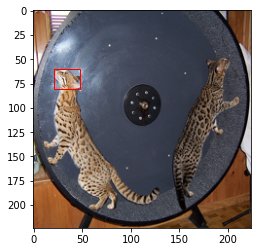

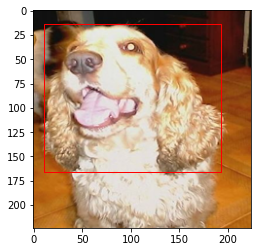

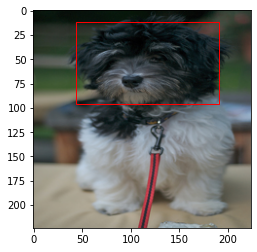

In [ ]:
## train dataset에서 1개의 image와 bbox를 읽어서 확인
for image, gt in val_dataset.take(3):
    
    '''그림을 그리기 위해서 bbox의 왼쪽 위 꼭지점 좌표를 계산하고, 
    xmin, ymin, w, h 각각을 image size에 맞게 scaling'''
    x = gt[:,0]
    y = gt[:,1]
    w = gt[:,2]
    h = gt[:,3]
    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[0].numpy() * IMG_SIZE)
    rect_h = int(h[0].numpy() * IMG_SIZE)
    
    ## 그림 그리기
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    plt.imshow(image[0])
    plt.show()

In [ ]:
# Sequential API를 사용하여 model 구성
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', 
                                  input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(4, activation='sigmoid'))
    return model

In [ ]:
def loss_fn(y_true, y_pred):
  return keras.losses.MeanSquaredError()(y_true, y_pred)

In [ ]:
## Create model, compile & summary
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2

In [ ]:
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.5,
                                                          staircase=True)
## optimizer는 RMSprop, loss는 mean squared error 사용
model.compile(keras.optimizers.RMSprop(lr_schedule), loss=loss_fn)

In [ ]:
## Train!
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=N_EPOCHS,
         validation_data=val_dataset,
         validation_steps=validation_steps)

Epoch 1/40
75/75 [==============================] - 9s 44ms/step - loss: 0.0254 - val_loss: 0.0232
Epoch 2/40
75/75 [==============================] - 4s 38ms/step - loss: 0.0225 - val_loss: 0.0209
Epoch 3/40
75/75 [==============================] - 3s 39ms/step - loss: 0.0210 - val_loss: 0.0186
Epoch 4/40
75/75 [==============================] - 3s 38ms/step - loss: 0.0188 - val_loss: 0.0225
Epoch 5/40
75/75 [==============================] - 3s 38ms/step - loss: 0.0173 - val_loss: 0.0164
Epoch 6/40
75/75 [==============================] - 3s 38ms/step - loss: 0.0161 - val_loss: 0.0158
Epoch 7/40
75/75 [==============================] - 3s 38ms/step - loss: 0.0147 - val_loss: 0.0157
Epoch 8/40
75/75 [==============================] - 3s 38ms/step - loss: 0.0141 - val_loss: 0.0146
Epoch 9/40
75/75 [==============================] - 3s 38ms/step - loss: 0.0117 - val_loss: 0.0140
Epoch 10/40
75/75 [==============================] - 3s 38ms/step - loss: 0.0113 - val_loss: 0.0146
Epoch 11/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


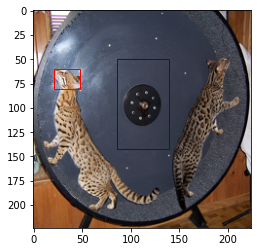

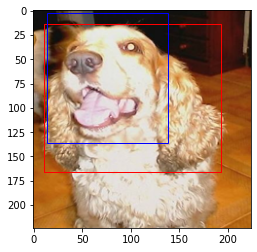

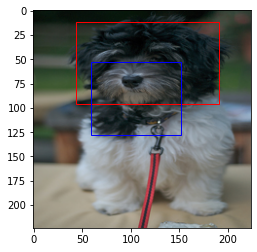

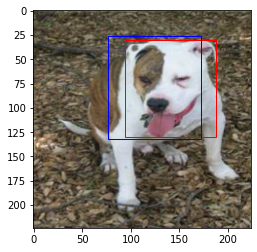

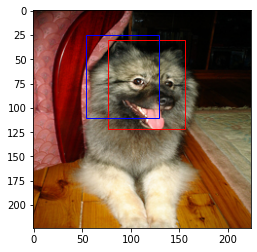

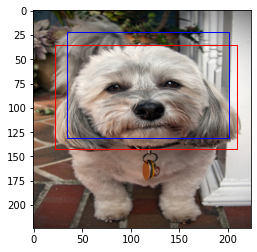

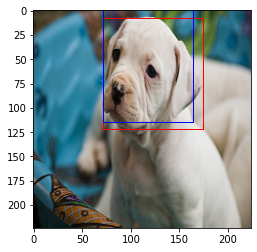

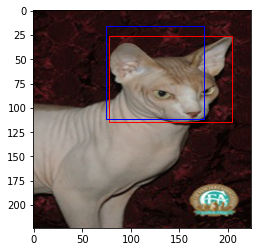

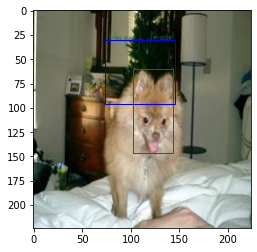

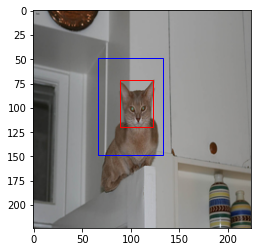

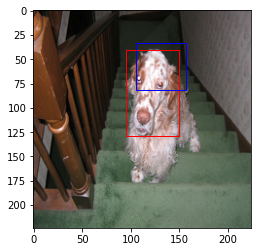

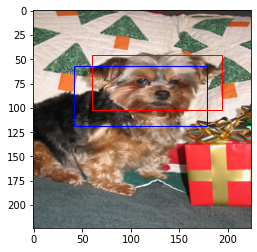

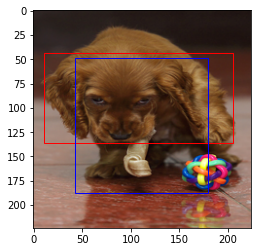

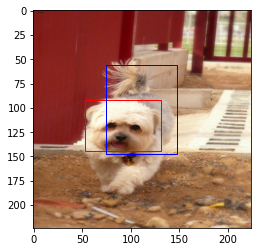

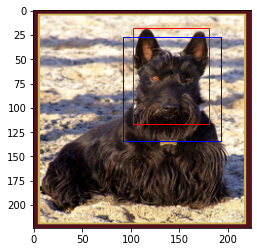

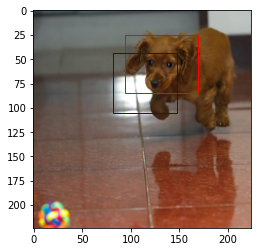

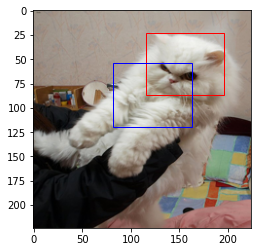

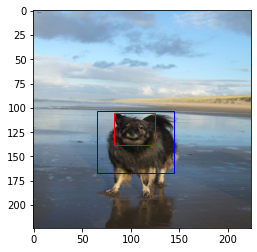

In [ ]:
## 예측한 bounding box와 ground truth box를 image에 같이 표시
## 정답은 빨간색 box, 예측은 파란색 box
idx = 0
num_imgs = validation_steps
for val_data, val_gt in val_dataset.take(num_imgs):
    ## 정답 box 그리기
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    
    ## 예측 box 그리기
    ## validation set에 대해서 bounding box 예측
    prediction = model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    ## image와 bbox 함께 출력
    plt.imshow(val_data[idx])
    plt.show()

In [ ]:
avg_iou = 0
num_imgs = validation_steps
res = N_VAL % N_BATCH #5
for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):
    ## 정답 box 그리기
    flag = (i == validation_steps-1)
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    prediction = model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    for idx in range(N_BATCH):
      if(flag):
        if idx == res:
          flag = False
          break          
      xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
      ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
      xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
      ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)

      pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
      pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
      pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
      pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)

      if xmin > pred_xmax or xmax < pred_xmin:        
        continue
      if ymin > pred_ymax or ymax < pred_ymin:        
        continue
      w_union = np.max((xmax, pred_xmax)) - np.min((xmin, pred_xmin))
      h_union = np.max((ymax, pred_ymax)) - np.min((ymin, pred_ymin))
      w_inter = np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
      h_inter = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))

      w_sub1 = np.abs(xmax - pred_xmax)
      h_sub1 = np.abs(ymax - pred_ymax)
      w_sub2 = np.abs(xmin - pred_xmin)
      h_sub2 = np.abs(ymin - pred_ymin)

      iou = (w_inter * h_inter) / ((w_union * h_union) - (w_sub1 * h_sub1) - (w_sub2 * h_sub2))
      avg_iou += iou / N_VAL

print(avg_iou)

0.5125321836583081
